This password strength evaluation tool was developed alongside the work presented in **Chapter 5: Practical AI in Cybersecurity** of my Master's thesis titled **Practical AI in Cyberwarfare and Cybersecurity**.  
The project was implemented by **Konstantinos Zafeiropoulos** (Student ID: `20390293`) at the  
**University of West Attica**  
**Faculty of Engineering, Department of Informatics and Computer Engineering**

Although the tool applies machine learning and entropy-based techniques to assess and visualize password strength, it was *not included in the final thesis submission* due to **time and length constraints** and the decision to focus on other tools that demonstrated **higher impact** and **technical relevance** in the field of cybersecurity.



In [1]:
# STEP 1: Import libraries
import pandas as pd
import sqlite3
import string
import math  
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# STEP 2: Load datasets

# A. Password Strength Classifier Dataset
df_a = pd.read_csv("/kaggle/input/password-strength-classifier-dataset/data.csv", on_bad_lines='skip')
df_a = df_a[["password", "strength"]]  # Already has both columns

# B. Password Dataset (passwords_dataset.csv)
df_b = pd.read_csv("/kaggle/input/password-dataset/passwords_dataset.csv")
df_b.rename(columns={"Password": "password", "Strength": "strength"}, inplace=True)
df_b = df_b[["password", "strength"]]  # Keep only necessary columns

# C. Password Strength & Vulnerability Dataset
df_c = pd.read_csv("/kaggle/input/passwords/passwords.csv")
df_c = df_c[["password"]]
df_c["strength"] = 0  # Assume all are weak (as noted in the dataset's description)

# D. Password Data SQLite
conn = sqlite3.connect("/kaggle/input/password-datas/password_data.sqlite")
df_d = pd.read_sql("SELECT * FROM Users;", conn)
df_d.rename(columns={"Password": "password", "Strength": "strength"}, inplace=True)
df_d = df_d[["password", "strength"]]

# Load RockYou2 (with counts) into a set of leaked passwords
rockyou_path = "/kaggle/input/rockyou2/rockyou-withcount.txt"

rockyou_leaked_set = set()

with open(rockyou_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            _, password = parts
            rockyou_leaked_set.add(password)

def is_rockyou_leaked(password):
    return password in rockyou_leaked_set
    

# STEP 3: Combine and clean all
df_all = pd.concat([df_a, df_b, df_c, df_d], ignore_index=True)
df_all.dropna(inplace=True)
df_all.drop_duplicates(subset="password", inplace=True)

def calculate_entropy(password):
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


# STEP 4: Feature extraction
def extract_features(pw):
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
    })


# Ensure all strength labels are in string form
df_all["strength"] = df_all["strength"].astype(str)
df_all["strength"] = df_all["strength"].str.capitalize()
valid_classes = ["Weak", "Medium", "Strong"]
df_all = df_all[df_all["strength"].isin(valid_classes)]

# Now extract features from filtered df
features = df_all["password"].apply(extract_features)
X = features
label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
y = df_all["strength"].map(label_map)


# STEP 5: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TEP 6: Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train, y_train)


# STEP 7: Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")


# STEP 8: Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("🔁 Cross-validation Scores:", cv_scores)
print(f"📊 Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")


# STEP 9: Save model
model.save_model("xgb_password_strength_model.json")


✅ Test Accuracy: 99.95%
🔁 Cross-validation Scores: [0.999  0.9995 0.9995 1.     0.9995]
📊 Mean CV Accuracy: 99.95%


In [2]:
# STEP 10: Predict on the full dataset
y_all_pred = model.predict(X)

# Map numeric predictions back to string labels
inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
df_all["Strength"] = [inv_label_map[i] for i in y_all_pred]
df_all.rename(columns={"password": "Passwords"}, inplace=True)

# STEP 11: Sample nicely-formatted output
print("🔍 Sample of predictions grouped by label:\n")

for label in ["Weak", "Medium", "Strong"]:
    print(f"🔐 {label} Passwords:")
    sample = df_all[df_all["Strength"] == label][["Passwords", "Strength"]].head(5)
    print(sample.to_string(index=False))
    print("-" * 40)


# STEP 12: Save TXT file with human-readable output
with open("Passwords_by_Strength.txt", "w", encoding="utf-8") as f:
    for label in ["Weak", "Medium", "Strong"]:
        f.write(f"🔐 {label} Passwords:\n")
        sample = df_all[df_all["Strength"] == label][["Passwords"]].head(100)
        for pw in sample["Passwords"]:
            f.write(f"  - {pw}\n")
        f.write("\n" + "-" * 40 + "\n\n")

print("✅ TXT file saved as Passwords_by_Strength.txt — check the 'Output' tab to download.")

🔍 Sample of predictions grouped by label:

🔐 Weak Passwords:
Passwords Strength
    <%r?.     Weak
    l(d_l     Weak
     c?m|     Weak
      U,m     Weak
      $@!     Weak
----------------------------------------
🔐 Medium Passwords:
     Passwords Strength
p3=x;>'=%<`^jx   Medium
       "lf`g(U   Medium
        WsW2:k   Medium
 &B?(ED;FOX~IM   Medium
     /LKL/P$)P   Medium
----------------------------------------
🔐 Strong Passwords:
      Passwords Strength
|+Z)kDTRYo:q{"(   Strong
gwcNB[oS5!n%OPJ   Strong
       ^vXjCCP6   Strong
    W,@/m#r4={m   Strong
p1{`GCY"7.~3Mie   Strong
----------------------------------------
✅ TXT file saved as Passwords_by_Strength.txt — check the 'Output' tab to download.


In [5]:
import math  


def check_password_strength(user_pw):
    entropy = calculate_entropy(user_pw)  # 🧠 use existing function

    features = pd.Series({
        "length": len(user_pw),
        "digits": sum(c.isdigit() for c in user_pw),
        "upper": sum(c.isupper() for c in user_pw),
        "lower": sum(c.islower() for c in user_pw),
        "symbols": sum(c in string.punctuation for c in user_pw),
        "spaces": int(" " in user_pw),
        "repeats": int(len(set(user_pw)) < len(user_pw)),
        "entropy": entropy  # ✅ add entropy to the model input
    }).to_frame().T

    prediction = model.predict(features)[0]
    inv_map = {0: "Weak", 1: "Medium", 2: "Strong"}
    return inv_map[prediction]

def practical_entropy(user_pw):
    length = len(user_pw)
    charset = 0
    if any(c.islower() for c in user_pw): charset += 26
    if any(c.isupper() for c in user_pw): charset += 26
    if any(c.isdigit() for c in user_pw): charset += 10
    if any(c in string.punctuation for c in user_pw): charset += 32  # typical symbol set
    if any(c.isspace() for c in user_pw): charset += 1

    if charset == 0: return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)


# Crack time estimator
def estimate_crack_time(user_pw):
    entropy = practical_entropy(user_pw)
    guesses = 2 ** entropy
    guess_rates = {
        "🌐 Online (1K/sec)": 1_000,
        "💻 CPU (1M/sec)": 1_000_000,
        "⚡ GPU (1B/sec)": 1_000_000_000,
        "👁️ Nation-state (100B/sec)": 100_000_000_000
    }

    times = {}
    for label, rate in guess_rates.items():
        seconds = guesses / rate
        times[label] = format_seconds(seconds)
    return times

# Format time output
def format_seconds(seconds):
    if seconds < 1:
        return f"{seconds:.4f} sec"  # more precision for < 1 sec
    elif seconds < 60:
        return f"{seconds:.2f} sec"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} min"
    elif seconds < 86400:
        return f"{seconds / 3600:.2f} hr"
    elif seconds < 31536000:
        return f"{seconds / 86400:.2f} days"
    elif seconds < 3.154e8:  # ~10 years
        return f"{seconds / 31536000:.2f} years"
    else:
        return f"{seconds:.2e} sec (~{seconds / 31536000:.1f} years)"

# Why it's weak
def explain_weakness(user_pw):
    reasons = []
    if len(user_pw) < 8:
        reasons.append("❗ Too short (less than 8 characters)")
    if not any(c.isupper() for c in user_pw):
        reasons.append("❗ No uppercase letters")
    if not any(c.islower() for c in user_pw):
        reasons.append("❗ No lowercase letters")
    if not any(c.isdigit() for c in user_pw):
        reasons.append("❗ No digits")
    if not any(c in string.punctuation for c in password):
        reasons.append("❗ No special symbols")
    if len(set(user_pw)) < len(user_pw) * 0.7:
        reasons.append("❗ Repeats characters too much")
    return reasons if reasons else ["✅ Looks balanced"]

# Interactive input and full report
user_pw = input("🔐 Enter a password to check its strength: ")

strength = check_password_strength(user_pw)
entropy = practical_entropy(user_pw)
crack_times = estimate_crack_time(user_pw)

print(f"\n💡 Strength: {strength}")
print(f"🔍 Entropy: {entropy} bits")
print("⏱ Estimated Crack Times:")
for method, time in crack_times.items():
    print(f"  {method}: {time}")

# Explain issues if weak
if strength == "Weak":
    print("\n📉 Reasons it's weak:")
    for reason in explain_weakness(user_pw):
        print(f" - {reason}")

# RockYou leak check
if is_rockyou_leaked(user_pw):
    print("⚠️ Found in RockYou leak!")
else:
    print("✅ Not found in RockYou.")

🔐 Enter a password to check its strength:  12345abcd



💡 Strength: Medium
🔍 Entropy: 46.53 bits
⏱ Estimated Crack Times:
  🌐 Online (1K/sec): 1.02e+11 sec (~3222.0 years)
  💻 CPU (1M/sec): 3.22 years
  ⚡ GPU (1B/sec): 1.18 days
  👁️ Nation-state (100B/sec): 16.93 min
⚠️ Found in RockYou leak!


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


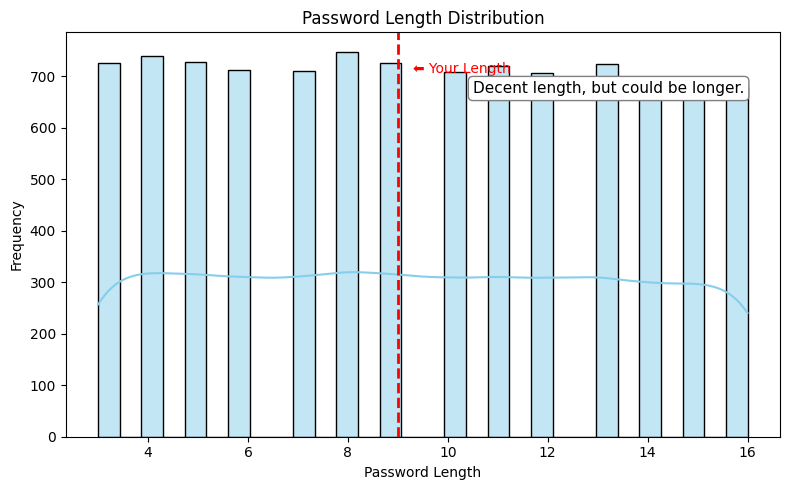

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


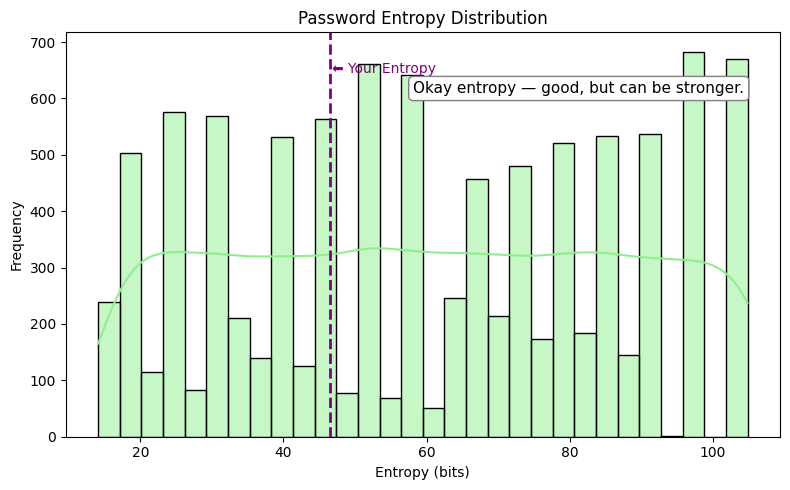

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your password's stats
length = len(user_pw)
entropy_val = practical_entropy(user_pw)

# Compute entropy for all passwords
df_all["entropy"] = df_all["Passwords"].apply(practical_entropy)

# ---- PLOT 1: Password Length ----
plt.figure(figsize=(8, 5))
sns.histplot(df_all["Passwords"].apply(len), bins=30, kde=True, color='skyblue')

# User arrow
plt.axvline(length, color='red', linestyle='--', linewidth=2)
plt.text(length + 0.3, plt.ylim()[1] * 0.9, "⬅️ Your Length", color='red', fontsize=10)

# Explanation text
if length < 8:
    comment = "Short passwords are easier to crack."
elif length < 12:
    comment = "Decent length, but could be longer."
else:
    comment = "Great length! Longer passwords are stronger."

plt.title("Password Length Distribution")
plt.xlabel("Password Length")
plt.ylabel("Frequency")
plt.text(0.95, 0.85, comment, transform=plt.gca().transAxes, ha='right', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

plt.tight_layout()
plt.show()

# ---- PLOT 2: Password Entropy ----
plt.figure(figsize=(8, 5))
sns.histplot(df_all["entropy"], bins=30, kde=True, color='lightgreen')

# User arrow
plt.axvline(entropy_val, color='purple', linestyle='--', linewidth=2)
plt.text(entropy_val + 0.3, plt.ylim()[1] * 0.9, "⬅️ Your Entropy", color='purple', fontsize=10)

# Explanation text
if entropy_val < 30:
    ent_comment = "Low entropy = predictable structure."
elif entropy_val < 50:
    ent_comment = "Okay entropy — good, but can be stronger."
else:
    ent_comment = "High entropy! Your password is very complex."

plt.title("Password Entropy Distribution")
plt.xlabel("Entropy (bits)")
plt.ylabel("Frequency")
plt.text(0.95, 0.85, ent_comment, transform=plt.gca().transAxes, ha='right', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

plt.tight_layout()
plt.show()